# Epidemiological simulation
Basic simulation using epidemiological methods. 

The user should be able to set the parameters of the disease and the size and connectivity of the cities and graph, and see the results and progress of the disease.

To visualize this, the graph should show nodes representing cities, where the size is proportional to the total population, and the color relates the percent of people infected. A measure of the number dead and recovered would also be insightful.

In [1]:
# Authored by Bryce Burgess
# Epidemiological simulation

import math
import numpy as np
import random as rand
import networkx as nx
%matplotlib notebook

np.random.seed(10)

# [ ] TODO multiple diseases
# [x] change population based on travelers

# Disease


In [2]:
class Disease():
    """
    a disease that can infect people in a city
    """
    def __init__(self, _inf_prob: float = 0.1, _death_prob: float = 0.01, _rec_prob: float = 0.05, _rein_prob: float = 0.001):
        self.infect_prob    = _inf_prob 
        self.death_prob     = _death_prob
        self.recover_prob   = _rec_prob
        self.reinfect_prob  = _rein_prob
        self.research_progress = 0
    
    def perfectly_researched(self, Graph):
        if self.research_progress >= 100:
            self.infect_prob = 0
            self.death_prob = 0
            self.recover_prob = 1
            self.reinfect_prob = 0

# Status


In [3]:

# one box refers to all the people in a city with a given status
class Box():
    """
    A status or potential status for a person
    """
    types = ['uninfected', 'infected', 'dead', 'recovered']
    def __init__(self, n, _type='uninfected'):
        self.n = n
        self.type = _type

    # allows for the changing of people between different boxes
    def transfer_people(self, n_change, box):
        """
        n_change: number of people to transfer
        box: a box to transfer people to
        """
        n_change = min(self.n, n_change)
        n_change = max(n_change, 0)
        self.n -= n_change
        box.n += n_change
        
        return n_change



# City/Region

In [11]:
# one city refers to all people within a region of all statuses
class City():
    """
    A large collection of people, mix of statuses, potentially infected by disease
    """
    
    def __init__(self, n_unf, n_inf, n_rec = 0, n_dead = 0, research_rate=np.random.random(), connections = []):
        self.name = self.generate_name()
        self.uninfected = Box(n_unf, _type='uninfected')
        self.infected = Box(n_inf, _type='infected')
        self.recovered = Box(n_rec, _type='recovered')
        self.dead = Box(n_dead, _type='dead')
        
        self.research_rate = research_rate

        self.total = self.uninfected.n + self.infected.n + self.recovered.n + self.dead.n
        self.con = connections
        
    def __str__(self):
        return "City: " + self.name

    def generate_name(self):
        n = ""
        for i in range(5):
            n += rand.choice("abcdefghijklmnopqrstuvwxyz")
        return n
        
    def update_city_status(self, disease):
        """
        disease: disease that affects the city
        """
        self.infect(disease)
        self.recover(disease)
        self.die(disease)
        self.research(disease)
        self.impact = (self.dead.n + self.infected.n)/(self.dead.n+self.infected.n + self.uninfected.n + self.recovered.n)
        return self.impact

    def infect(self, disease, prob_fn = "ratio"):
        """
        disease: a disease that can infect people in a city
        prob_fn: how to calculate the rate of infection (ratio, erf)
        """
        # [ ] TODO include option to be dependent upon number dead
        # [ ] TODO adjust infected/reinfected per disease instead of total
        if prob_fn == "ratio":
            new_infected = disease.infect_prob   * self.uninfected.n * self.infected.n/(self.uninfected.n + self.infected.n)
            reinfected   = disease.reinfect_prob * self.recovered.n  * self.infected.n/(self.recovered.n  + self.infected.n) 

        elif prob_fn == "erf": 
            new_infected = disease.infect_prob   * self.uninfected.n * math.erf(self.infected.n/self.uninfected)
            reinfected   = disease.reinfect_prob * self.recovered.n  * math.erf(self.infected.n/self.recovered)

            self.uninfected.transfer_people(new_infected, self.infected)
            self.recovered.transfer_people(reinfected, self.infected)

    def recover(self, disease):
        """
        disease: a disease that people will recover from
        """
        new_recovered = disease.recover_prob * self.infected.n
        return self.infected.transfer_people(new_recovered, self.recovered)
        

    def die(self, disease):
        """
        disease: a disease that people will die of
        """
        died = disease.death_prob * self.infected.n
        return self.infected.transfer_people(died, self.dead)

    def research(self, disease):
        """
        disease: a disease that cities can research
        """
        # [ ] TODO allow for research progress
        # is research associated only with disease? (assumes perfect communication)
        disease.research_progress += self.research_rate
        return disease.research_progress
        # is research associated with city/cities? (assumes no communication)
        
    # Transfer from any self box to a connection's box of same type
    def travel(self, n_people, box1, box2):
        """
        n_people: the number of people that are traveling
        box1: the box people are traveling from
        box2: the box people are traveling to
        """
        if box1.type == box2.type:
            return box1.transfer_people(n_people, box2)
        else:
            return 0
        
    def print_info(self, d):
        print(f"uninfected: {self.uninfected.n}")
        print(f"infected: {self.infected.n}")
        print(f"recovered: {self.recovered.n}")
        print(f"dead: {self.dead.n}")
        print(f"research for disease: {d.research_progress}")

    # [ ] TODO implement ability to conduct research with connected cities


# Graph
The graph is the representation of a connected collection of cities or regions. Connections between areas are created and removed here.

In [12]:

# Geographic and transportation linkage of cities
class Graph():
    """
    collection of connected cities
    """
    def __init__(self, n_cities, bidirectional=True):
        """
        n_cities: integer of a number of cities to include in a graph
        """
        self.n = n_cities
        self.city_list = []
        self.bidirectional = bidirectional
    
    def add_cities(self, Cities):
        for city in Cities:
            self.city_list.append(city)
            self.make_edges()

    def make_edges(self, con_prob = 0.15):
        self.edges = set()
        for city1 in self.city_list:
            for city2 in self.city_list:
                if np.random.rand() < con_prob and city1 is not city2:
                    self.edges.add((city1.name, city2.name))
                    if self.bidirectional:
                        self.edges.add((city2.name, city1.name))
        
    def remove_edge(self, city1, city2):
        self.edges.remove((city1.name, city2.name))
        if self.bidirectional:
            self.edges.remove((city2.name, city1.name))

    def add_edge(self, city1, city2):
        """
        city1: a city to create connection (source if not bidirectional)
        city2: a city to create connection (target if not bidirectional)
        bidirectional: determine whether all connections are mutual
        """
        
        self.edges.add((city1.name, city2.name))
        if self.bidirectional:
            self.edges.add((city2.name, city1.name))

    def display(self):
        impact_list = [city.impact for city in self.city_list]
        
        graph = nx.from_edgelist(self.edges)
        nx.draw_networkx(graph, node_color=impact_list)

# Initialize and run simulation

<IPython.core.display.Javascript object>


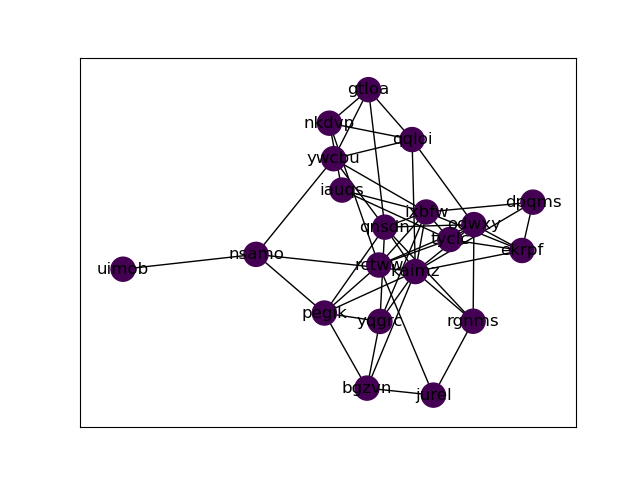

In [18]:

# Initialize disease
disease = Disease()

# Initialize cities in graph
num_cities = 20
n_infected = 100
n_uninfected = 5
city_list = []
for i in range(num_cities):
    city_list.append(City(n_infected, n_uninfected))

# Initialize graph
graph = Graph(num_cities)
graph.add_cities(city_list)
graph.make_edges()

# Simulation
duration = 100
dt = 0.1
for t in np.arange(0, duration, dt):
    for city in graph.city_list:
        city.update_city_status(disease)
        # [ ] TODO implement travel probability and conditions
        # [ ] TODO implement research across cities
    
        
        
graph.display()

<IPython.core.display.Javascript object>


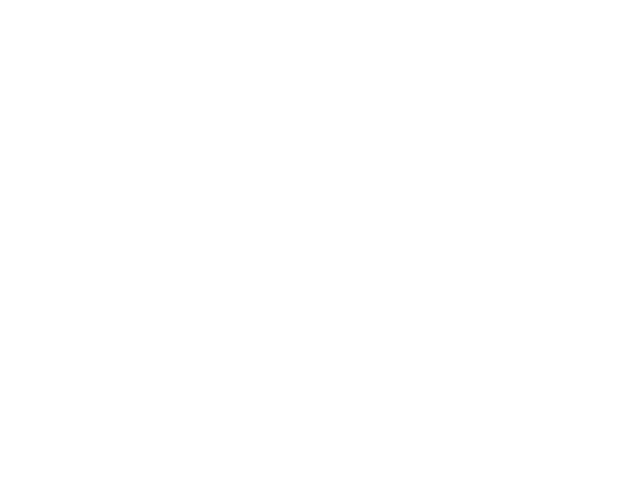

In [15]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
plot, = plt.plot([], [], 'ro')
plt.axis('off')

graph = Graph(num_cities)
graph.add_cities(city_list)
graph.make_edges()


def init():
    graph.nodes.set_array()
    return graph.nodes,

def update():
    impact_list = []
    for city in graph.city_list:
        impact_list.append(city.update_city_status(disease))
    
        
    graph.nodes.set_array(impact_list)
    return graph.nodes,

ani = FuncAnimation(fig, update, frames=duration, blit=True)
plt.show()

<IPython.core.display.Javascript object>


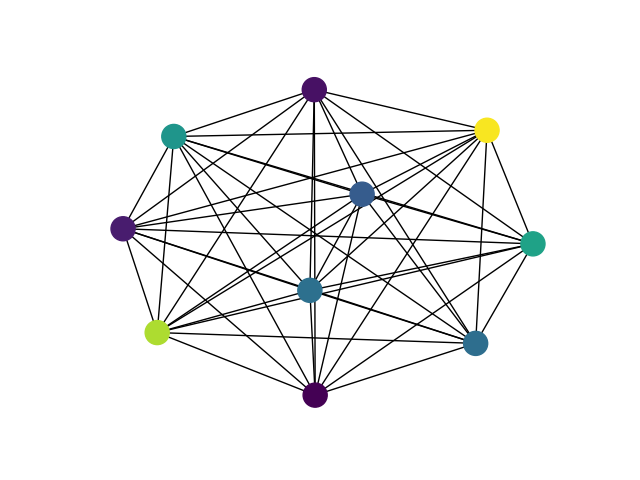

<matplotlib.collections.PathCollection object at 0x00000223241FB2B0> <matplotlib.collections.LineCollection object at 0x00000223241FB610>


In [17]:
import numpy as np
import matplotlib.pyplot as plt#; plt.close('all')
import networkx as nx
from matplotlib.animation import FuncAnimation

def animate_nodes(G, node_colors, pos=None, *args, **kwargs):

    # define graph layout if None given
    if pos is None:
        pos = nx.spring_layout(G)

    # draw graph
    nodes = nx.draw_networkx_nodes(G, pos, *args, **kwargs)
    edges = nx.draw_networkx_edges(G, pos, *args, **kwargs)
    print(nodes, edges)
    plt.axis('off')

    def update(ii):
        # nodes are just markers returned by plt.scatter;
        # node color can hence be changed in the same way like marker colors
        nodes.set_array(node_colors[ii])
        return nodes,

    fig = plt.gcf()
    animation = FuncAnimation(fig, update, interval=50, frames=len(node_colors), blit=True)
    return animation

total_nodes = 10
graph = nx.complete_graph(total_nodes)
time_steps = 20
node_colors = np.random.randint(0, 100, size=(time_steps, total_nodes))
animation = animate_nodes(graph, node_colors)